In [1]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta
from dateutil.relativedelta import *
import matplotlib.patches as mpatches
import mwparserfromhell
from mw import Timestamp
from mw.xml_dump import Iterator
import re
from collections import defaultdict
# Timestamp('yyyy-mm-ddThh:mm:ssZ')

In [2]:
# to make interactive plotting possible
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# make plots a bit nicer
import matplotlib.pyplot as plt
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

In [3]:
def rlink_status(df_table, start_frame, end_frame):
    
    start_frame = Timestamp(start_frame)
    end_frame = Timestamp(end_frame)
    
    remain_red = 0
    new_here = 0
    disappear = 0
    become_blue = 0
    become_blue_fast = 0
    born_die_here = 0
    
    remain_red += sum((df_table['start_date'] < start_frame) & (df_table['end_date'] > end_frame))
    
    new_here += sum((df_table['start_date'] > start_frame) & (df_table['start_date'] < end_frame) & (df_table['end_date'] >= end_frame))
    
    become_blue += sum((df_table['start_date'] < start_frame) & (df_table['end_date'] <= end_frame) & (df_table['link_title'].isin(blinks_mintime_list)))
    
    disappear += sum((df_table['start_date'] < start_frame) & (df_table['end_date'] <= end_frame) & (~df_table['link_title'].isin(blinks_mintime_list)))
    
    become_blue_fast = sum((df_table['start_date'] > start_frame) & (df_table['end_date'] <= end_frame) & (df_table['link_title'].isin(blinks_mintime_list)))
    
    born_die_here = sum((df_table['start_date'] > start_frame) & (df_table['end_date'] <= end_frame) & (~df_table['link_title'].isin(blinks_mintime_list)))
    
    return {'start_frame': start_frame, 'end_frame': end_frame,
            'remain_red': remain_red, 'disappear': disappear,
            'become_blue': become_blue, 'become_blue_fast': become_blue_fast,
            'new_here': new_here, 'born_die_here': born_die_here}

## Plot 1. Number of red links throughout the time

In [6]:
df_red_less_unique = pd.read_csv('../working_files/'+'df_red_less_unique.csv', sep='^')

In [7]:
df_red_less_unique_time = df_red_less_unique.groupby(['parent_page', 'rvtimestamp']).size().reset_index(name='counts')

In [8]:
parents = df_red_less_unique['parent_page'].unique()

len(parents)

948

In [9]:
data_range10years = pd.date_range(start="2010-01-01",end="2020-05-01")

In [10]:
dd_strings = [[str(x)[:10], 0] for x in data_range10years]

In [11]:
accum_rlinks_arr = np.zeros((1, len(dd_strings)))

for parent in parents:

    page_subset = df_red_less_unique_time[df_red_less_unique_time['parent_page'] == parent][['rvtimestamp', 'counts']]
    page_rvtime_dict = dict((x, y) for x, y in page_subset.to_numpy())

    new_rlinks = []
    for reftime in dd_strings:
        rlinks_number = page_rvtime_dict.get(reftime[0])
        if rlinks_number != None:
            new_rlinks.append(rlinks_number)
        else:
            new_rlinks.append(0)

    for rv in range(len(new_rlinks)):
        if new_rlinks[rv] == 0:
            new_rlinks[rv] = new_rlinks[rv-1]

    new_rlinks_arr = np.array(new_rlinks)

    accum_rlinks_arr = accum_rlinks_arr + new_rlinks_arr

In [12]:
accum_rlinks_arr

array([[8225., 8225., 8225., ..., 7024., 7024., 7021.]])

In [13]:
for i in range(len(dd_strings)):
    dd_strings[i][1] = accum_rlinks_arr[0][i]

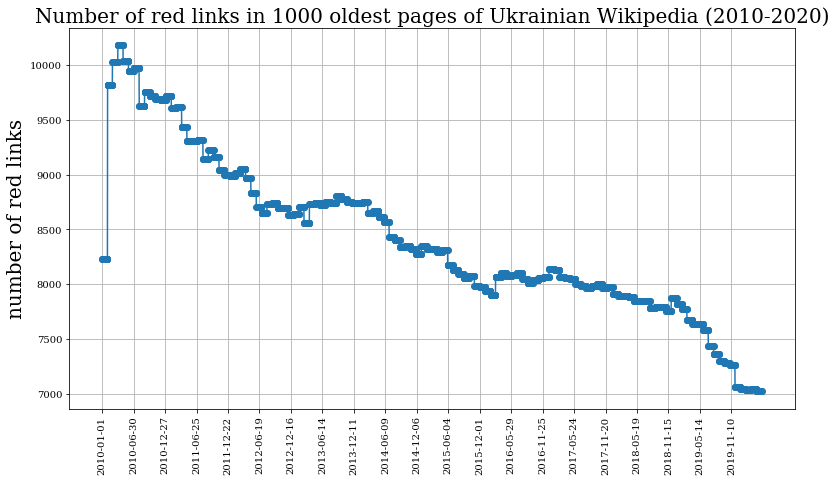

In [14]:
data_plot = [(i, d[0],d[1]) for i,d in enumerate(dd_strings)]
#data_plot_filter = [d for d in data_plot if d[2] != 0]

x_ticks = [d[0] for d in data_plot[::180]]
x_ticks_str = [d[1] for d in data_plot[::180]]

plt.figure(figsize=(13,7))
plt.plot([d[0] for d in data_plot], [d[2] for d in data_plot], '-o')
plt.xticks(x_ticks, x_ticks_str, rotation=90);
plt.grid('on')

plt.title("Number of red links in 1000 oldest pages of Ukrainian Wikipedia (2010-2020)", fontsize=20)
plt.ylabel("number of red links", fontsize=20)
plt.show()

## Plot 2. Arising of new red links ???

## Plot 3. Status of red links in 2010-2020 (remain red, become blue, disappear) - check

In [16]:
link_status_df_clean = pd.read_pickle('/media/andrii/earth/Katia/CS/!redlinks_project/red-links-v2.0/working_files/'+'link_status_1000pages_after2010.pkl')

df_red = link_status_df_clean.loc[link_status_df_clean['link_status'] == 'red link']
df_red = df_red[['parent_page', 'rvtimestamp', 'link_title', 'link_status']]

del link_status_df_clean

In [17]:
page_creation_df = pd.read_csv('../data/'+'quarry-44795-get-the-timestamp-for-first-revision-of-all-articles-in-ukwiki-run466602.csv')

page_creation_df['page_title'] = page_creation_df['page_title'].str.lower()

blinks_mintime_list = list(page_creation_df['page_title'])

In [18]:
# get the latest revisions of pages

latest_revisions_df = pd.read_csv('../working_files/'+'latest_revisions_df.csv')

latest_revisions_df.columns = ['parent_page', 'rvtimestamp']

latest_rvs_records = latest_revisions_df.to_dict('records')

In [19]:
df_red_check_dict_ref = {}
for r in latest_rvs_records:
    new_key = r['parent_page']
    new_value = r['rvtimestamp']
    t = str(new_value)
    new_value_timestamp = Timestamp(t[:4]+'-'+t[4:6]+'-'+t[6:8]+'T'+t[8:10]+':'+t[10:12]+':'+t[12:14]+'Z')
    df_red_check_dict_ref[new_key] = new_value_timestamp

In [20]:
clean_pages = 0
for k, v in df_red_check_dict_ref.items():
    index = df_red.loc[(df_red['parent_page'] == k) & (df_red['rvtimestamp'] == v)].index
    try:
        df_red.loc[index[0],['rvtimestamp']] = Timestamp('2020-12-31T00:00:00Z')
    except:
        clean_pages += 1
print('There are ' + str(clean_pages) + ' pages without red links in Ukrainian Wikipedia')

There are 155 pages without red links in Ukrainian Wikipedia


In [21]:
# create a table with the earliest and the latest revision of a red link

rlinks_maxtime = df_red.groupby(['link_title'], sort=False)['rvtimestamp'].max()
rlinks_maxtime_df = rlinks_maxtime.to_frame()

rlinks_mintime = df_red.groupby(['link_title'], sort=False)['rvtimestamp'].min()
rlinks_mintime_df = rlinks_mintime.to_frame()

mintime_maxtime_rlinks_df = pd.merge(rlinks_mintime_df, rlinks_maxtime_df, on='link_title')

mintime_maxtime_rlinks_df.columns = ['start_date', 'end_date']

mintime_maxtime_rlinks_df.reset_index(level=0, inplace=True)

In [22]:
# create time slices for counting rlinks

start_frame = mintime_maxtime_rlinks_df['start_date'].min()
end_frame = Timestamp('2020-06-01T00:00:00Z')

time_margins = [datetime.fromtimestamp(start_frame)]
time_margins_str = [str(datetime.fromtimestamp(start_frame).date())]
new_date = datetime.fromtimestamp(start_frame)
while new_date <= datetime.fromtimestamp(end_frame):
    new_date = new_date + relativedelta(months=+1)
    str_date = str(new_date.date())
    time_margins.append(new_date)
    time_margins_str.append(str_date)

In [23]:
# define the status of a red link in a particular time moment

d_total = {'start_frame': [], 'end_frame': [], 'remain_red': [], 'disappear': [],
     'become_blue': [], 'become_blue_fast': [], 'new_here': [], 'born_die_here': []}

for i in range(len(time_margins)-1):
    d_frame = rlink_status(mintime_maxtime_rlinks_df, time_margins[i], time_margins[i+1])
    for k,v in d_frame.items():
        d_total[k].append(v)

rlinks_lifespan = pd.DataFrame.from_dict(d_total)

rlinks_lifespan['start_date_str'] = time_margins_str[:125]

rlinks_lifespan['end_date_str'] = time_margins_str[1:126]

In [24]:
# plot the changes in red links' status in 2010-2020

x_data = np.arange(len(rlinks_lifespan))
x_data_str = [x[:-3] for x in rlinks_lifespan['start_date_str'].values]

x_interval = 6
x_ticks = [i for i in x_data[::x_interval]]
x_ticks_str = [s for s in x_data_str[::x_interval]]

remain_red = rlinks_lifespan['remain_red'].values
disappear = rlinks_lifespan['disappear'].values
become_blue = rlinks_lifespan['become_blue'].values
become_blue_fast = rlinks_lifespan['become_blue_fast'].values
new_here = rlinks_lifespan['new_here'].values
born_die_here = rlinks_lifespan['born_die_here'].values

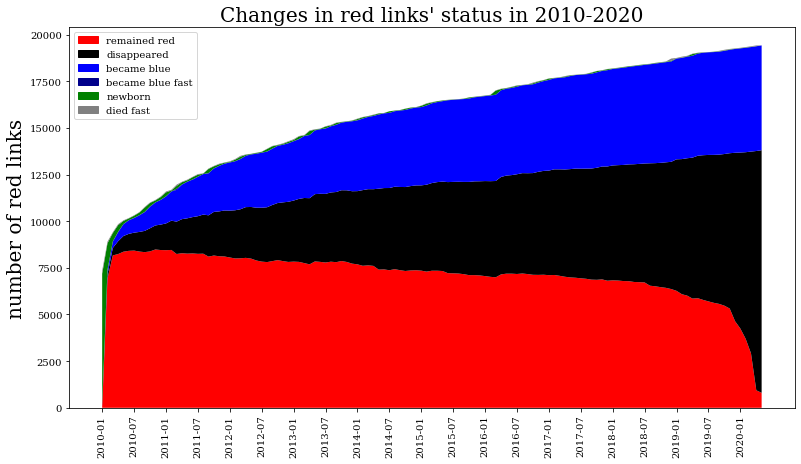

In [25]:
plt.figure(figsize=(13,7))

plt.stackplot(x_data, remain_red, disappear, become_blue, become_blue_fast, new_here, born_die_here, \
              colors=['red', 'black', 'blue', 'darkblue', 'green', 'grey'])
plt.title('Changes in red links\' status in 2010-2020', fontsize=20)
plt.ylabel("number of red links", fontsize=20)
plt.xticks(x_ticks, x_ticks_str, rotation=90)

remain_red_patch = mpatches.Patch(color='red', label='remained red')
disappear_patch = mpatches.Patch(color='black', label='disappeared')
become_blue_patch = mpatches.Patch(color='blue', label='became blue')
become_blue_fast_patch = mpatches.Patch(color='darkblue', label='became blue fast')
new_here_patch = mpatches.Patch(color='green', label='newborn')
born_die_here_patch = mpatches.Patch(color='grey', label='died fast')
plt.legend(handles=[remain_red_patch, disappear_patch, become_blue_patch, become_blue_fast_patch, new_here_patch, born_die_here_patch], \
           loc='upper left')

plt.show()

## Plot 4. Creation of new pages in Ukrainian Wikipedia (2010-2020)

In [28]:
page_creation_df = pd.read_csv('../data/'+'quarry-44795-get-the-timestamp-for-first-revision-of-all-articles-in-ukwiki-run466602.csv')

In [29]:
page_creation_df.page_creation_timestamp = page_creation_df.page_creation_timestamp.apply(lambda x: Timestamp(np.int64(x)))

page_creation_df_after2010 = page_creation_df.drop(page_creation_df[page_creation_df.page_creation_timestamp.map(lambda x: int(x.strftime("%Y")) < 2010)].index)

page_creation_df_after2010['page_creation_timestamp'] = page_creation_df_after2010.page_creation_timestamp.apply(lambda x: datetime.fromtimestamp(x).date().replace(day=1))

page_creation_df_after2010['page_creation_timestamp'] = page_creation_df_after2010.page_creation_timestamp.apply(lambda x: str(x))

grouped_page_creation = page_creation_df_after2010.groupby(['page_creation_timestamp']).size().reset_index(name='counts')

In [30]:
x = grouped_page_creation.page_creation_timestamp.values
y = grouped_page_creation.counts.values

data_plot = [(i, d) for i,d in enumerate(x)]

x_ticks = [d[0] for d in data_plot[::6]]
x_ticks_str = [d[1] for d in data_plot[::6]]

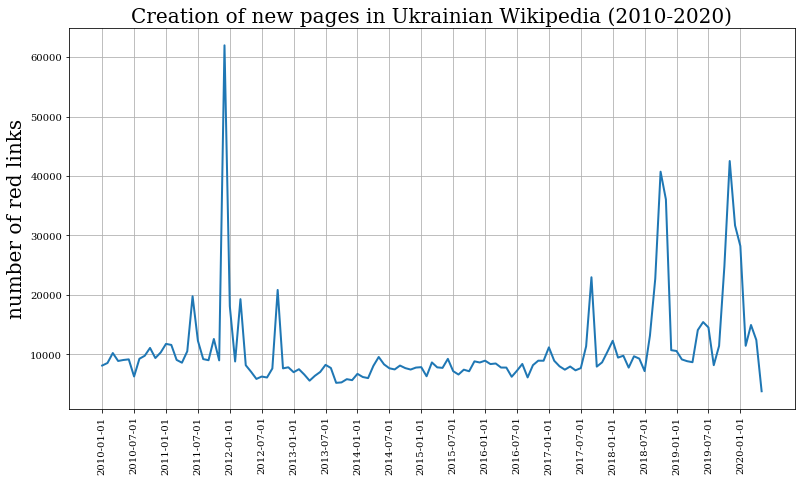

In [31]:
plt.figure(figsize=(13,7))
plt.plot(x, y, linewidth=2.0)
plt.xticks(x_ticks, x_ticks_str, rotation=90);
plt.grid('on')

plt.title("Creation of new pages in Ukrainian Wikipedia (2010-2020)", fontsize=20)
plt.ylabel("number of red links", fontsize=20)
plt.show()